#Kernel Non-negative Tensor Factorization

In [1]:
%matplotlib inline

import matplotlib

import numpy as np
from sklearn.metrics import pairwise_kernels as K #to compute kernel matrix
import scipy.io as sio #to load mat files
from OKMF import OKMF #Online Kernel Matrix Factorization
from kntf import Kntf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#1. Loading dataset CMU Faces

$\mathcal{TF}\in\mathbb{R}_+^{30\times11\times21\times1024}$

In [2]:
sio.whosmat('../datasets/CMU(30x11x21x1024).mat')

[('FullTensor', (30, 11, 21, 1024), 'uint8')]

In [3]:
matTF = sio.loadmat('../datasets/CMU(30x11x21x1024).mat')#loading tensor of formatted faces' images

In [4]:
TF = matTF['FullTensor']

In [5]:
TF.shape

(30, 11, 21, 1024)

1.1 Tensor matrization

$MF\in\mathbb{R}_+^{6930\times1024}$

In [6]:
MF = np.reshape(TF,(30*11*21,1024))

Some images which compound the tensor:

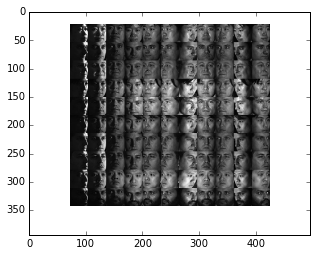

In [7]:
img=mpimg.imread('../datasets/faces_sample.png')
imgplot = plt.imshow(img)

#2. Compute Online Kernel Matrix Factorization

2.1 Computing Online kernel-NMF $\phi(X) \approx \phi(X)WH$ (Esteban algorithm adaptation)

Loss function:

$\min_{W,h_i}\frac{1}{2}||\phi(x_i)-\phi(X)Wh_i||^2+\frac{\lambda}{2}||W||_F^2+\frac{\alpha}{2}||h_i||_F^2$

Algorithm iterate assesing the following updated rules (SGD):

$h_t = (W^T_{t-1}K(X,X)W_{t-1}-\alpha I) W^T_{t-1}K(X,x_t)$

$W_t = W_{t-1}-\gamma(k(X,x_t)h_t^T-k(X,X)W_{t-1}h_th_t^T+\lambda W_{t-1})$

In [43]:
#Parameters:
Gamma = 0.01
Lambda = 0.0001
Alpha = 0.3
sigma = 2**-1

In [44]:
#online kernel NMF algorithm (by Esteban)
ok = OKMF(6930,10,100,2,Gamma,Lambda,Alpha,'rbf',gamma=sigma)
#(budgetSize,latentTopics,minibatchSize,epochs,Gamma,Lambda,Alpha,metric,**kwds):

In [45]:
ok.fit(MF,calculateErrors=True)

Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq
Using lstsq


Error:

$2\epsilon = tr(K(x_i,x_i))+tr(h^TW^TK(X,x_i))+tr(K(X,x_i)^TWh)+tr(W^TK(X,X)h^TWh)+\lambda tr(W^TW)+\alpha tr(h^Th)$

In [46]:
ok.trainErrors

array([ -1.69227451e+14,   1.49439136e+30,   1.49418218e+30])

2.2 Compute error as $||WH-\phi(X)||_F/||\phi(X)||_F$

In [21]:
error = np.linalg.norm(np.dot(ok.W,ok.H) ,'fro')/np.linalg.norm(ok._KB,'fro')

SyntaxError: invalid syntax (<ipython-input-21-cacf44931215>, line 1)

In [17]:
print error

0.999999999973


2.3 Parameters' selection

In [ ]:
kf = KFold(X.shape[0],n_folds=4,shuffle=True)

In [ ]:
from time import clock

f = open('../outcomes/Results_cmu_faces.csv','w')
f.write('sigma,Budget,Gamma,Lambda,Alpha,tr0,tr1,tr2,ts0,ts1,ts2,time\n')
c = 0.0
budget = 6930
for exp in [-1,0,1]:
        sigma = 2**exp
        for Gamma in [0.01,0.1,0.8]:
            for Lambda in [0.0001, 0.1,0.3]:
                for Alpha in [0.3,0.4,0.6]:
                    suma0 = 0.0
                    suma1 = 0.0
                    suma2 = 0.0
                    suma3 = 0.0
                    suma4 = 0.0
                    suma5 = 0.0
                    time = 0.0
                    c += 1
                    print 'rbf',(c / 224.0)
                    #for train,test in kf:
                    #    ok = OKMF(budget,10,100,2,Gamma,Lambda,Alpha,'rbf',gamma=sigma)
                    #    t0 = clock()
                    #    ok.fit(X,Xt,True)
                    #    ok.fit(X,calculateErrors=True)
                    #    time += clock() - t0
                    #    suma0 += ok.trainErrors[0]
                    #    suma1 += ok.trainErrors[1]
                    #    suma2 += ok.trainErrors[2]
                    #    suma3 += ok.validationErrors[0]
                    #    suma4 += ok.validationErrors[1]
                    #    suma5 += ok.validationErrors[2]
                    ok = OKMF(budget,10,100,5,Gamma,Lambda,Alpha,'rbf',gamma=sigma)
                    t0 = clock()                    
                    ok.fit(MF,calculateErrors=True)
                    time += clock() - t0
                    suma0 += ok.trainErrors[0]
                    suma1 += ok.trainErrors[1]
                    suma2 += ok.trainErrors[2]
                    suma3 += ok.trainErrors[2]
                    suma4 += ok.trainErrors[2]
                    suma5 += ok.trainErrors[2]
                    suma0/=4.0
                    suma1/=4.0
                    suma2/=4.0
                    suma3/=4.0
                    suma4/=4.0
                    suma5/=4.0
                    time/=4.0
                    val = (sigma,budget,Gamma,Lambda,Alpha)
                    val += (suma0,suma1,suma2,suma3,suma4,suma5,time)
                    s = '{},{},{},{},{},{},{},{},{},{},{},{}\n'.format(*val)
                    f.write(s)
f.close()

In [13]:
param_values = np.genfromtxt('../outcomes/Results_cmu_faces.csv', delimiter=',',skip_header=1)

In [21]:
param_values.shape

(81, 12)

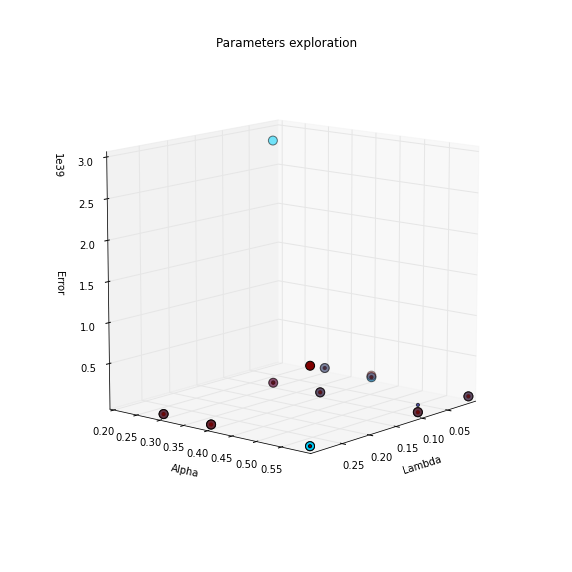

In [42]:
from mpl_toolkits.mplot3d import Axes3D

#fig = plt.scatter(param_values[:,3],param_values[:,4],c=param_values[:,7],s=param_values[:,0])
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')

ax.set_title('Parameters exploration')
ax.set_xlabel('Lambda')
ax.set_ylabel('Alpha')
ax.set_zlabel('Error')

ax.set_xlim(0.0001, 0.3)
ax.set_ylim(0.2, 0.6)
ax.set_zlim(2e+29, 3e+39)

ax.view_init(elev=12, azim=40)              # elevation and angle
ax.dist=12                                  # distance

sc = ax.scatter(
           param_values[:,3], param_values[:,4], param_values[:,7],  # data
           c=param_values[:,0],                            # marker colour
           #marker='o',                                # marker shape
           s=(param_values[:,2]*100)                                 # marker size
           )
#plt.colorbar(sc)
plt.show()                                            # render the plot


In [34]:
min(param_values[:,7])

2.12455138591e+29

# Convex Kernel - NMF

In [2]:
from CNMF import CNMF #Source: Esteban Paez
from sklearn import datasets

In [3]:
iris = datasets.load_iris()
iris.data.shape

(150, 4)

In [20]:
splatent = 4
objects = iris.data.shape[0]
#attributes = iris.data.shape[1]
attributes = 150
#X = np.random.rand(objects,attributes)
KX = K(iris.data,iris.data,'linear')
epochs = 2
W0 = np.random.rand(objects,splatent)
G0 = np.random.rand(splatent,attributes)

In [38]:
XP = (abs(KX)+ KX)/2
XN = (abs(KX)- KX)/2
W=W0
G=G0

In [78]:
np.dot(XN,np.dot(W.T,np.dot(G.T,G))).shape

ValueError: shapes (150,150) and (4,150) not aligned: 150 (dim 1) != 4 (dim 0)

In [70]:
n = np.dot(XP,G) + np.dot(XN,np.dot(W,np.dot(G.T,G)))

ValueError: shapes (150,150) and (4,150) not aligned: 150 (dim 1) != 4 (dim 0)

In [79]:
W,G,error = CNMF(iris.data,epochs,W0,G0,calculateErrors = True)

ValueError: shapes (150,4) and (150,4) not aligned: 4 (dim 1) != 150 (dim 0)

In [73]:
#Initialization
splatent = 2
objects = 100
attributes = 3
X = np.random.rand(objects,attributes)
KX = np.dot(X,X.T)
epochs = 2
W0 = np.random.rand(objects,splatent)
G0 = np.random.rand(splatent,attributes)

In [70]:
W,G,error = CNMF(X,epochs,W0,G0,calculateErrors = True)

ValueError: shapes (100,3) and (2,100) not aligned: 3 (dim 1) != 2 (dim 0)

In [76]:
np.dot(X.T,W0)

array([[ 24.58270696,  21.45834436],
       [ 24.18164956,  24.94593442],
       [ 26.30794224,  23.26503157]])